In [25]:
import numpy as np
import random
import argparse
import torch 
import torch.nn as nn
from torch.autograd import grad 
import torch_geometric 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_add_pool
import sys 
import time
import wandb
from tqdm import tqdm
sys.path.append("egnn/")
from models.egnn_clean import egnn_clean as eg
from model import EGNN_Ener
from tqdm import tqdm

In [4]:
dataset = torch.load("/home/distileq/home/code/EGNN/Datasets/aspirin/train_full_pyg.pth")
dataset[0]

Data(edge_index=[2, 298], cell=[3, 3], charges=[21], energy=-17635.845703125, energy_weight=1.0, forces=[21, 3], forces_weight=1.0, node_attrs=[21, 3], positions=[21, 3], shifts=[298, 3], stress=[1, 3, 3], stress_weight=0.0, unit_shifts=[298, 3], virials=[1, 3, 3], virials_weight=0.0, weight=1.0)

In [31]:
class EGNN_Ener(nn.Module):
    def __init__(
        self, 
        node_input_dim=3, 
        node_output_dim=3, 
        edge_input_dim=3,
        hidden_dim=32, 
        num_layers=2
        ):
        super().__init__()
        # self.proj_layer = nn.Linear(3, node_output_dim, bias=False)
        self.egnn = eg.EGNN(
                            in_node_nf=node_input_dim, 
                            hidden_nf=hidden_dim, 
                            out_node_nf=node_output_dim, 
                            in_edge_nf=edge_input_dim, 
                            n_layers=num_layers
                        )
        self.linear = nn.Linear(node_output_dim, 3, bias=False)
        # self.linear = nn.Linear(3, 3, bias=False)


    def forward(self, batch, device):
        h = batch['node_attrs']
        x_orig = batch['positions'].to(device) 
        # x_proj = self.proj_layer(x_orig)    # project coordinates into embeddings 
        edges = [row for row in batch['edge_index']]
        edge_attr = x_orig[edges[0]]-x_orig[edges[1]]
        h_new, x_new = self.egnn(h, x_orig, edges, edge_attr)
        pred_forces = self.linear(x_new)
        return pred_forces

In [32]:
device = torch.device("cuda")
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)
model = EGNN_Ener(node_input_dim=dataset[0]['node_attrs'].shape[1],
                      node_output_dim=3,
                      edge_input_dim=3, 
                      hidden_dim=64,
                      num_layers=2
                      ).to(device)
batch = next(iter(train_loader)).to(device)
preds = model(batch, device)

In [33]:
def loss_fn(pred_forces, batch):
    if 'is_root' in batch:
        root_nodes = batch['is_root']
        return torch.mean(torch.square(batch["forces"][root_nodes] - pred_forces[root_nodes]))
    else:
        return torch.mean(torch.square(batch["forces"] - pred_forces))

In [34]:
model.train()
train_loss = 0
train_epoch_losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in tqdm(range(500)):
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred_forces = model(batch, device)
        loss = loss_fn(pred_forces, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().detach().item()
    train_epoch_losses.append(train_loss / len(train_loader))
    # print(f"Epoch: {epoch + 1}, Train loss: {train_loss / len(train_loader)}")

100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


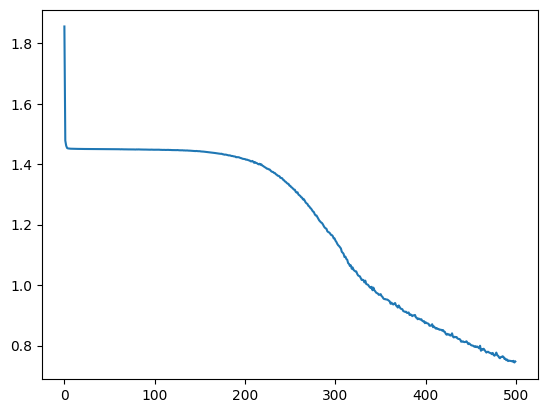

In [35]:
import matplotlib.pyplot as plt 

plt.plot(list(range(500)), train_epoch_losses)
plt.show()